Aperçu des données brutes :
     Sender Receiver   Amount
47  User_18  User_17  4593.28
48  User_20  User_11  2448.14
49   User_1   User_5  9500.00
50   User_5  User_10  9400.00
51  User_10   User_1  9300.00

Cycles suspects détectés : 309
Cycle 1: ['User_18', 'User_3', 'User_2', 'User_1', 'User_6', 'User_15'] -> Retour à l'envoyeur
Cycle 2: ['User_18', 'User_3', 'User_2', 'User_1', 'User_4', 'User_12', 'User_6', 'User_15'] -> Retour à l'envoyeur
Cycle 3: ['User_18', 'User_3', 'User_2', 'User_1', 'User_4', 'User_13', 'User_15'] -> Retour à l'envoyeur
Cycle 4: ['User_18', 'User_3', 'User_2', 'User_1', 'User_4', 'User_13', 'User_20', 'User_12', 'User_6', 'User_15'] -> Retour à l'envoyeur
Cycle 5: ['User_18', 'User_3', 'User_2', 'User_1', 'User_5', 'User_4', 'User_12', 'User_6', 'User_15'] -> Retour à l'envoyeur
Cycle 6: ['User_18', 'User_3', 'User_2', 'User_1', 'User_5', 'User_4', 'User_13', 'User_15'] -> Retour à l'envoyeur
Cycle 7: ['User_18', 'User_3', 'User_2', 'User_1', 'User_5', 'U

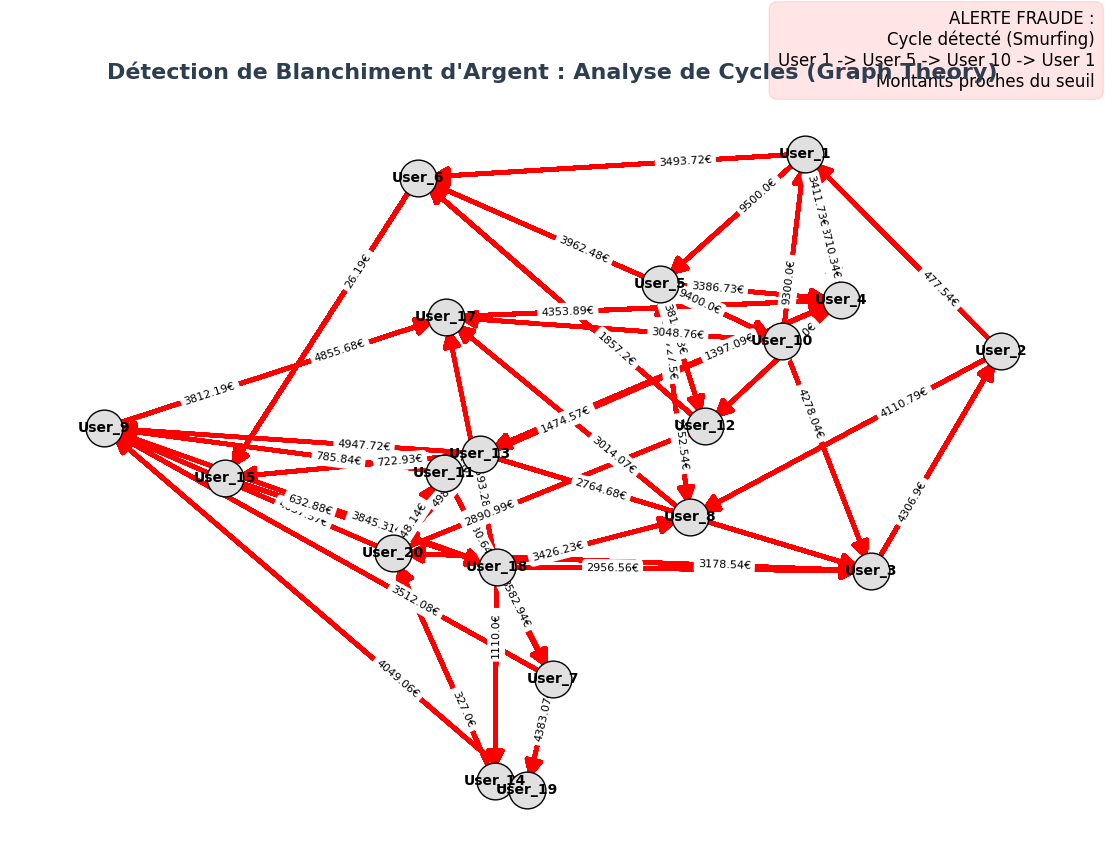

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

# --- 1. CONFIGURATION & GÉNÉRATION DE DONNÉES ---
# Pour que le résultat soit reproductible
random.seed(42)
np.random.seed(42)

# Création de 20 individus (Nœuds)
individuals = [f"User_{i}" for i in range(1, 21)]

# Génération de 50 transactions aléatoires (Bruit de fond)
transactions = []
for _ in range(50):
    sender = random.choice(individuals)
    receiver = random.choice(individuals)
    
    # On évite qu'il s'envoie de l'argent à lui-même
    if sender != receiver:
        # Montants aléatoires entre 10 et 5000 €
        amount = round(random.uniform(10, 5000), 2)
        transactions.append({'Sender': sender, 'Receiver': receiver, 'Amount': amount})

# --- INJECTION DU SCHÉMA DE BLANCHIMENT (SMURFING) ---
# Schéma : A -> B -> C -> A (Boucle fermée) avec des montants similaires (structuration)
# On va utiliser User_1, User_5 et User_10 comme complices
fraud_scheme = [
    {'Sender': 'User_1', 'Receiver': 'User_5', 'Amount': 9500.00}, # Juste sous le seuil de déclaration de 10k
    {'Sender': 'User_5', 'Receiver': 'User_10', 'Amount': 9400.00}, # Un peu moins (frais fictifs)
    {'Sender': 'User_10', 'Receiver': 'User_1', 'Amount': 9300.00}  # Retour à l'envoyeur
]

# Ajout de la fraude aux données
transactions.extend(fraud_scheme)

# Création du DataFrame Pandas
df = pd.DataFrame(transactions)

print("Aperçu des données brutes :")
print(df.tail()) # On voit nos transactions frauduleuses à la fin

# --- 2. MODÉLISATION EN GRAPHE ---
# Nous utilisons un Graphe Dirigé (DiGraph) car l'argent a un sens de circulation
G = nx.from_pandas_edgelist(
    df, 
    source='Sender', 
    target='Receiver', 
    edge_attr='Amount', 
    create_using=nx.DiGraph()
)

# --- 3. ALGORITHME DE DÉTECTION DE CYCLES ---
# Les cycles simples indiquent que l'argent revient à son point de départ
cycles = list(nx.simple_cycles(G))

# Filtrage : On ne s'intéresse qu'aux cycles de plus de 2 personnes (A->B->A est courant, A->B->C->A est suspect)
suspicious_cycles = [c for c in cycles if len(c) > 2]

print(f"\nCycles suspects détectés : {len(suspicious_cycles)}")
for idx, cycle in enumerate(suspicious_cycles):
    print(f"Cycle {idx+1}: {cycle} -> Retour à l'envoyeur")

# Identification des arêtes (liens) qui font partie de la fraude pour la coloration
suspicious_edges = []
for cycle in suspicious_cycles:
    # On reconstruit les paires (Sender, Receiver) du cycle
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        suspicious_edges.append((u, v))

# --- 4. VISUALISATION (DATA STORYTELLING) ---
plt.figure(figsize=(14, 10))

# Disposition des nœuds (Spring Layout écarte les nœuds pour la lisibilité)
pos = nx.spring_layout(G, k=0.6, seed=42) 

# Séparation des arêtes normales et frauduleuses
all_edges = G.edges()
normal_edges = [e for e in all_edges if e not in suspicious_edges]

# Dessin des Nœuds
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='#e0e0e0', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Dessin des Arêtes NORMALES (Gris, fines, discrètes)
nx.draw_networkx_edges(
    G, pos, 
    edgelist=normal_edges, 
    width=1, 
    alpha=0.3, 
    edge_color='gray', 
    arrowstyle='-|>', 
    arrowsize=10
)

# Dessin des Arêtes SUSPECTES (Rouge, épaisses, visibles)
nx.draw_networkx_edges(
    G, pos, 
    edgelist=suspicious_edges, 
    width=3, 
    alpha=1.0, 
    edge_color='#FF0000', # ROUGE VIF
    arrowstyle='-|>', 
    arrowsize=25
)

# Affichage des montants (Étiquettes sur les arêtes)
edge_labels = nx.get_edge_attributes(G, 'Amount')
# On arrondit pour la lisibilité
formatted_edge_labels = {k: f"{v}€" for k, v in edge_labels.items()}

nx.draw_networkx_edge_labels(
    G, pos, 
    edge_labels=formatted_edge_labels, 
    font_size=8, 
    label_pos=0.3,
    font_color='black'
)

# Titres et Légendes
plt.title("Détection de Blanchiment d'Argent : Analyse de Cycles (Graph Theory)", fontsize=16, fontweight='bold', color='#2c3e50')
plt.axis('off') # On cache les axes X/Y inutiles

# Petit encadré explicatif (Storytelling)
plt.text(
    x=1.0, y=1.0, 
    s="ALERTE FRAUDE :\nCycle détecté (Smurfing)\nUser 1 -> User 5 -> User 10 -> User 1\nMontants proches du seuil", 
    fontsize=12, 
    bbox=dict(facecolor='red', alpha=0.1, edgecolor='red', boxstyle='round,pad=0.5'),
    transform=plt.gca().transAxes,
    ha='right'
)

# Sauvegarde
plt.savefig("Financial_Crime_Graph.png", dpi=300, bbox_inches='tight')
plt.show()

In [2]:
%pip install networkx pandas matplotlib

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 14.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
